In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tqdm import tqdm_notebook

In [2]:
pd.set_option('display.max_rows', 500)

In [3]:
file_path = 'C:/Users/Jacob/Documents/datasets/amsterdamumcdb-1.0.2/'
save_path = 'C:/Users/Jacob/Documents/datasets/amsterdamumcdb-1.0.2-processed/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [4]:
adm = pd.read_csv(os.path.join(save_path, 'admissions.csv'))
adm.head()

Unnamed: 0  patientid  admissionid  admissioncount location  urgency  \
0           4          4            4               1    IC&MC        0   
1           5          5            5               1       IC        1   
2           9          9            9               1       IC        0   
3          12         12           12               1       IC        0   
4          15         14           15               1       IC        1   

                                   origin  admittedat admissionyeargroup  \
0      Verpleegafdeling zelfde ziekenhuis           0          2010-2016   
1  Eerste Hulp afdeling zelfde ziekenhuis           0          2010-2016   
2                                     NaN           0          2003-2009   
3                                     NaN           0          2003-2009   
4  Eerste Hulp afdeling zelfde ziekenhuis           0          2010-2016   

   dischargedat  ...  destination gender agegroup  dateofdeath  weightgroup  \
0     180900000  ...           19    Man    70-79          NaN        70-79   
1     246420000  ...           31    Man    50-59          NaN        60-69   
2     242040000  ...           15  Vrouw    70-79          NaN        70-79   
3     627960000  ...           29    Man    18-39          NaN        90-99   
4     893220000  ...    Overleden    Man    60-69  812280000.0        60-69   

   weightsource heightgroup  heightsource        specialty icudeath  
0  Anamnestisch     170-179  Anamnestisch  Cardiochirurgie    False  
1       Geschat     160-169       Gemeten       Longziekte    False  
2           NaN        159-           NaN  Cardiochirurgie    False  
3           NaN         NaN           NaN              NaN    False  
4       Geschat     160-169       Geschat      Cardiologie     True  

[5 rows x 21 columns]

## Drug items data

In [5]:
# Lose quite a lot of info here
# Use `administered` instead of `dose` as they may not be the same
drg_cols = ['admissionid', 'ordercategory', 'item', 'rate', 'rateunit', 'administered', 'administeredunit', 'start', 'stop', 'duration']
drg = pd.read_csv(os.path.join(file_path, "drugitems.csv"), encoding='latin-1', usecols=drg_cols)
print(drg.shape)
drg = drg.loc[drg["admissionid"].isin(adm["admissionid"])]
print(drg.shape)
drg.head()

(4907269, 10)
(2001819, 10)


admissionid                      ordercategory                 item  \
192            4  Injecties Antimicrobiele middelen  Cefazoline (Kefzol)   
193            4  Injecties Antimicrobiele middelen  Cefazoline (Kefzol)   
194            4  Injecties Antimicrobiele middelen  Cefazoline (Kefzol)   
195            4   Injecties CZS/Sedatie/Analgetica              Morfine   
196            4   Injecties CZS/Sedatie/Analgetica              Morfine   

     rate rateunit  administered administeredunit     start      stop  \
192   0.0      NaN           1.0                g  12780000  12840000   
193   0.0      NaN           1.0                g  34380000  34440000   
194   0.0      NaN           1.0                g  55980000  56040000   
195   NaN      NaN           2.5               mg  31140000  31200000   
196   NaN      NaN           2.5               mg  44640000  44700000   

     duration  
192         1  
193         1  
194         1  
195         1  
196         1

In [6]:
drg["admissionid"].nunique()

5239

In [7]:
drg = drg.loc[drg["item"].isin(drg["item"].value_counts().index.to_list()[:50])]
print(drg.shape)

(1551960, 10)


In [8]:
# Verification that all drug items have the same administered units.
drg.groupby("item")["administeredunit"].value_counts(dropna=False)

item                                     administeredunit
(V/A)Ventolin:Atrovent 1:1               ml                   24385
(V/A/M)Ventolin:Atrovent:Mucomyst 1:1:1  ml                   23185
Actrapid (Insuline)                      IE                   60838
Calcium Glubionaat (Calcium Sandoz)      g                     8695
                                         mg                       4
                                         fg                       1
Captopril (Capoten)                      mg                   10136
Carbasalaatcalcium (Ascal)               mg                    9215
Cefotaxim (Claforan)                     g                    18881
                                         mg                      37
Ceftriaxon (Rocephin)                    g                    10026
                                         mg                       2
Cernevit Multivitaminen                  Geen                  9051
                                         None             

In [9]:
# Keep the top administeredunit for each item
keep_items = drg.groupby("item")["administeredunit"].agg(pd.Series.mode).index
keep_administeredunit = drg.groupby("item")["administeredunit"].agg(pd.Series.mode)
for item, unit in tqdm_notebook(zip(keep_items, keep_administeredunit), total=len(keep_items)):
    drg = drg.drop(drg.loc[(drg["item"] == item) & (drg["administeredunit"] != unit)].index)
print(drg.shape)
drg.groupby("item")["administeredunit"].value_counts(dropna=False)


(1541491, 10)


item                                     administeredunit
(V/A)Ventolin:Atrovent 1:1               ml                   24385
(V/A/M)Ventolin:Atrovent:Mucomyst 1:1:1  ml                   23185
Actrapid (Insuline)                      IE                   60838
Calcium Glubionaat (Calcium Sandoz)      g                     8695
Captopril (Capoten)                      mg                   10136
Carbasalaatcalcium (Ascal)               mg                    9215
Cefotaxim (Claforan)                     g                    18881
Ceftriaxon (Rocephin)                    g                    10026
Cernevit Multivitaminen                  Geen                  9051
Clonidine (Catapresan)                   mg                   14896
Dopamine (Inotropin)                     mg                   10735
Drukzak                                  ml                   23312
Erythromycine (Erythrocine)              mg                   10409
Fentanyl                                 mg               

In [10]:
# Verification that all drug rates have the same rate units.
drg.groupby("item")["rateunit"].value_counts(dropna=False)

item                                     rateunit
(V/A)Ventolin:Atrovent 1:1               NaN          24385
(V/A/M)Ventolin:Atrovent:Mucomyst 1:1:1  NaN          23185
Actrapid (Insuline)                      ml/uur       60371
                                         NaN            467
Calcium Glubionaat (Calcium Sandoz)      ml/uur        6923
                                         NaN           1772
Captopril (Capoten)                      NaN          10136
Carbasalaatcalcium (Ascal)               NaN           9215
Cefotaxim (Claforan)                     NaN          18881
Ceftriaxon (Rocephin)                    NaN          10026
Cernevit Multivitaminen                  NaN           9051
Clonidine (Catapresan)                   ml/uur       14896
Dopamine (Inotropin)                     ml/uur       10735
Drukzak                                  NaN          23312
Erythromycine (Erythrocine)              NaN          10409
Fentanyl                                 ml/uur   

In [11]:
# Keep the top rateunit for each item
keep_items = drg.groupby("item")["rateunit"].agg(lambda x: x.mode(dropna=False)).index
keep_rateunit = drg.groupby("item")["rateunit"].agg(lambda x: x.mode(dropna=False))
for item, unit in tqdm_notebook(zip(keep_items, keep_rateunit), total=len(keep_items)):
    if str(unit) == 'nan':
        drg = drg.drop(drg.loc[(drg["item"] == item) & drg["rateunit"].notnull()].index)
    else:
        drg = drg.drop(drg.loc[(drg["item"] == item) & (drg["rateunit"] != unit)].index)
print(drg.shape)
drg.groupby("item")["rateunit"].value_counts(dropna=False)


(1521908, 10)


item                                     rateunit
(V/A)Ventolin:Atrovent 1:1               NaN          24385
(V/A/M)Ventolin:Atrovent:Mucomyst 1:1:1  NaN          23185
Actrapid (Insuline)                      ml/uur       60371
Calcium Glubionaat (Calcium Sandoz)      ml/uur        6923
Captopril (Capoten)                      NaN          10136
Carbasalaatcalcium (Ascal)               NaN           9215
Cefotaxim (Claforan)                     NaN          18881
Ceftriaxon (Rocephin)                    NaN          10026
Cernevit Multivitaminen                  NaN           9051
Clonidine (Catapresan)                   ml/uur       14896
Dopamine (Inotropin)                     ml/uur       10735
Drukzak                                  NaN          23312
Erythromycine (Erythrocine)              NaN          10409
Fentanyl                                 ml/uur       63501
Furosemide (Lasix)                       ml/uur       12475
Gelofusine                               NaN      

In [12]:
drg.groupby("item")["administered"].describe()

count         mean          std  \
item                                                                          
(V/A)Ventolin:Atrovent 1:1                24385.0     2.032069     0.314962   
(V/A/M)Ventolin:Atrovent:Mucomyst 1:1:1   23185.0     2.998577     0.131836   
Actrapid (Insuline)                       60371.0    15.880302    16.256847   
Calcium Glubionaat (Calcium Sandoz)        6923.0     5.095943     2.296200   
Captopril (Capoten)                       10136.0    23.012207    61.618284   
Carbasalaatcalcium (Ascal)                 9215.0    83.625393    19.880113   
Cefotaxim (Claforan)                      18881.0     1.052910     5.135609   
Ceftriaxon (Rocephin)                     10026.0     2.000299     0.045768   
Cernevit Multivitaminen                    9051.0     1.003536     0.059358   
Clonidine (Catapresan)                    14896.0     0.253891     0.902492   
Dopamine (Inotropin)                      10735.0    62.904624    68.311034   
Drukzak                                   23312.0   327.358312   185.828545   
Erythromycine (Erythrocine)               10409.0   289.420309   119.617472   
Fentanyl                                  63501.0     0.792232     1.820914   
Furosemide (Lasix)                        12475.0    61.229355    95.299086   
Gelofusine                                18613.0   461.228604   126.666902   
Glucose 5 %                               12250.0   351.488062   200.230646   
Haloperidol (Haldol)                      18564.0     2.622501     1.473428   
Heparine                                  21600.0  8641.960212  6564.103854   
Hydrocortison (Solu Cortef)               27673.0    71.429155    31.502971   
Hypromellose                              61117.0     1.010476     0.212232   
Insuline aspart (Novorapid)               33085.0    10.895620    10.948057   
Kaliumchloride (KCL)                      54342.0    25.476118    14.721288   
Kaliumchloride drank                      12790.0    26.006185     8.305091   
Macrogol (Movicolon)                      20413.0     1.024494     0.182554   
Macrogol (Movicolon)X                     26017.0    63.697275  1385.692073   
Magnesiumsulfaat (MgSO4)                  14876.0     1.996439     0.320098   
Metoprolol (Selokeen )                    13263.0    53.458463    33.536151   
Metronidazol (Flagyl)                     10959.0   499.990875     4.108839   
Midazolam (Dormicum)                      60380.0    27.744968    21.259465   
Morfine                                    9907.0     2.801141     1.241008   
NaCL 0,9% spuit                           61294.0    40.411973    15.828170   
NaCl 0,45%/Glucose 2,5%                   54224.0   360.720256   201.469260   
NaCl 0,9 %                                29127.0   349.204033   249.212722   
Nadroparine (Fraxiparine)                 26814.0  3052.254643   765.674503   
Nicardipine (Cardene)                      8724.0     7.747638     8.581876   
Noradrenaline (Norepinefrine)            126448.0     2.433814     5.059827   
Nutrison Protein Plus                     33196.0   657.609801   376.198847   
Nutrison Standaard                        13432.0   652.813493   377.085684   
Oculentum simplex oogzalf                 14079.0     1.013424     0.200238   
Oxazepam (Seresta)                        12805.0    15.688598    13.067102   
Pantoprazol (Pantozol)                    16434.0    40.003164     4.675419   
Paracetamol                               72321.0   983.220033    90.752392   
Propofol (Diprivan)                       77377.0   496.687207   406.463052   
Ri-Lac (Ringers lactaat)                  16891.0   444.568250   226.300177   
SDD drank (4 x dgs)                       85936.0    10.134868     0.871955   
SDD pasta (4 x dgs)                       80066.0     1.003235     0.179516   
Thiamine (Vitamine B1)                    11927.0   102.360191    30.697849   
Velosuline (Insuline)                     22447.0    18.330981    16.101132   
Xylometazoline 

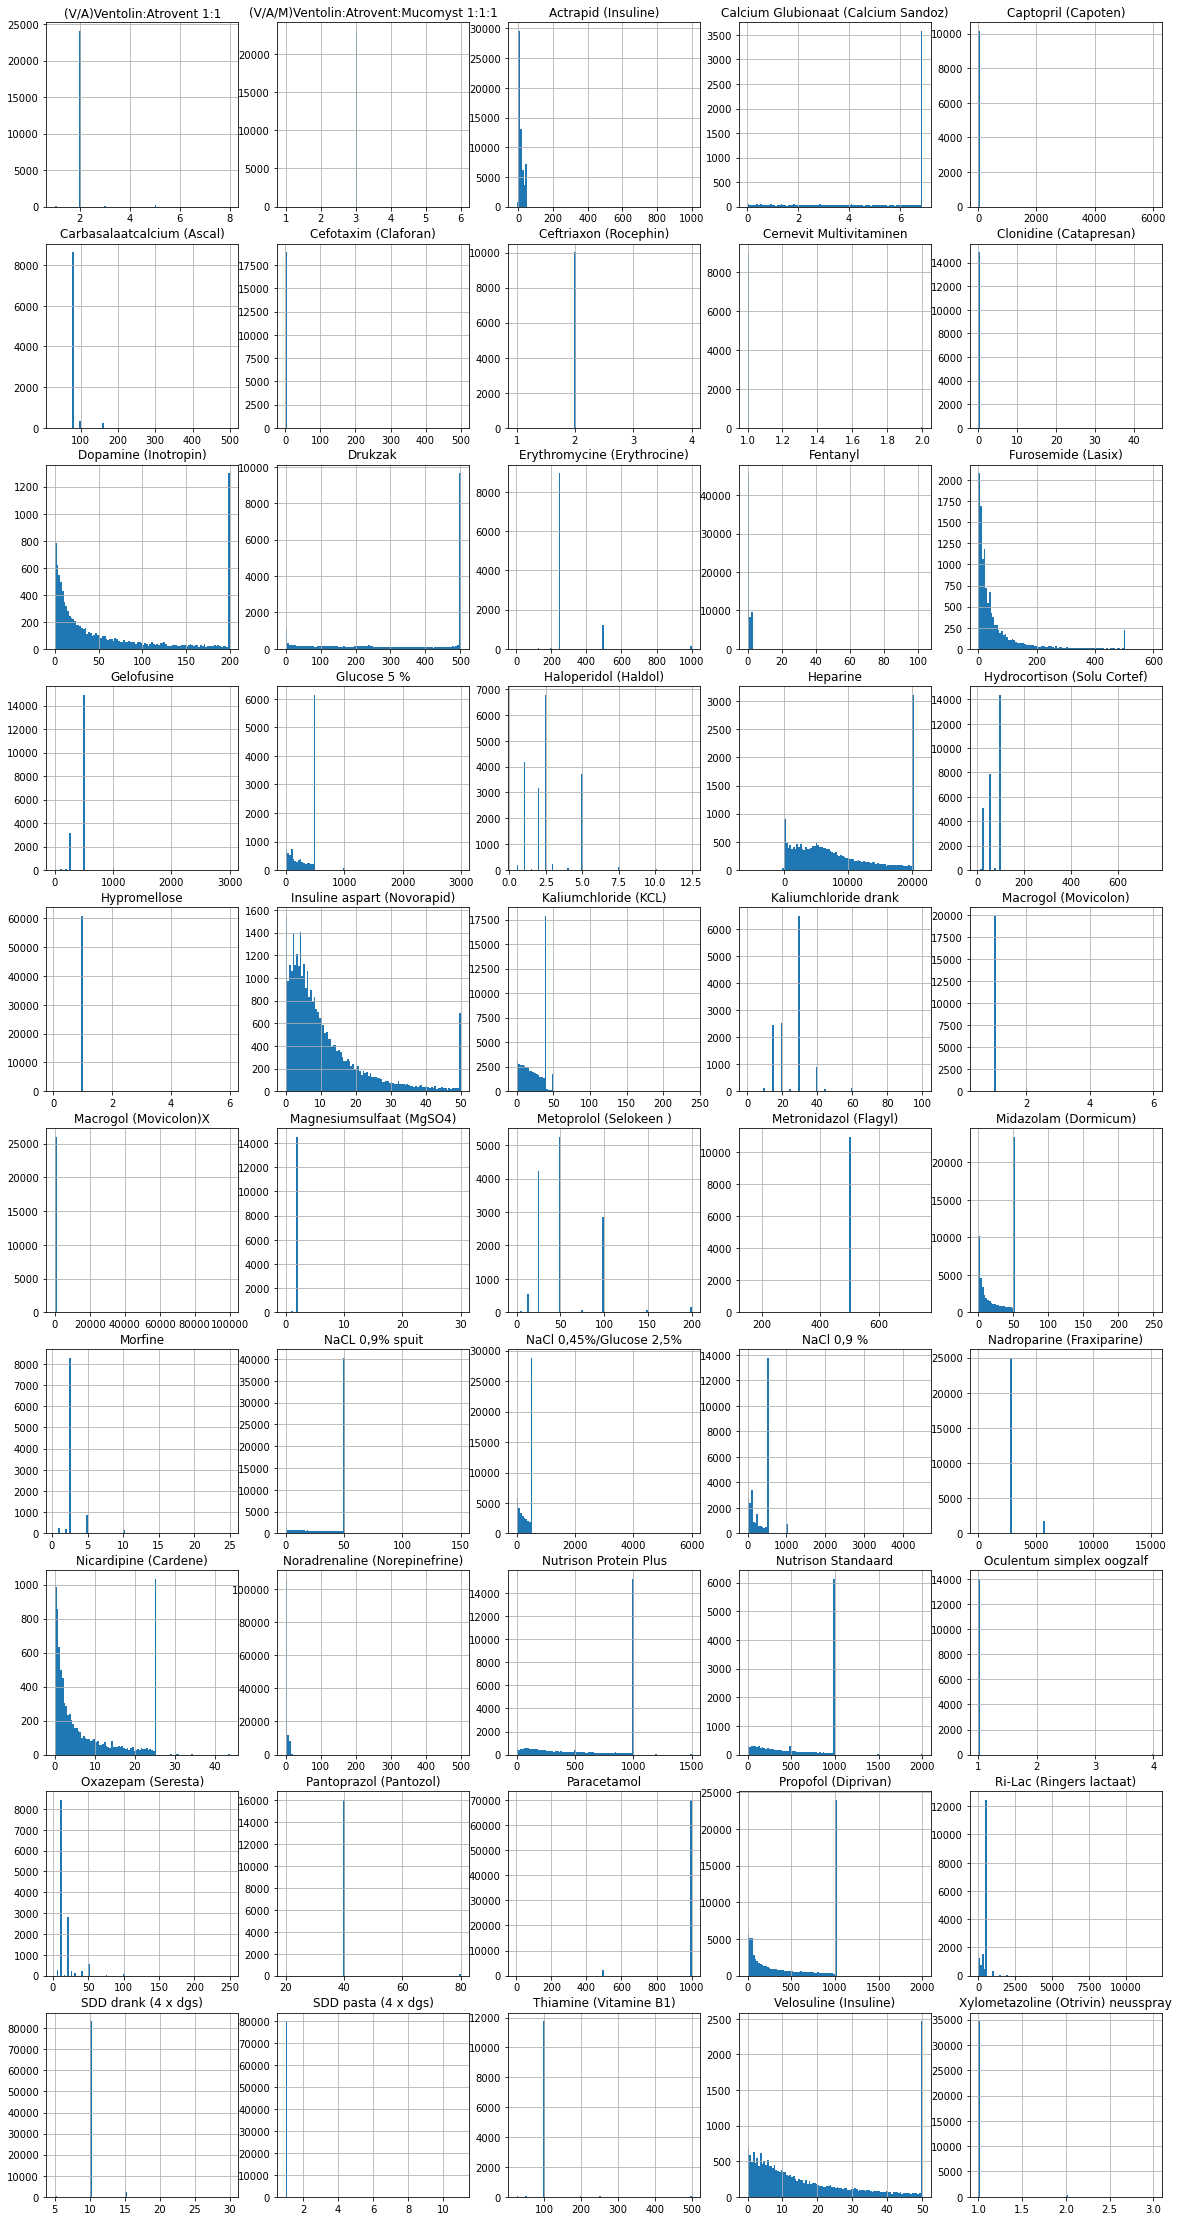

In [13]:
plt.figure(figsize=(20, 40))
for i, item in enumerate(sorted(drg["item"].unique())):
    plt.subplot(10, 5, 1+i)
    drg["administered"][drg["item"] == item].hist(bins=100)
    plt.title(item)

### Clean outliers

In [14]:
# Clean administered outliers

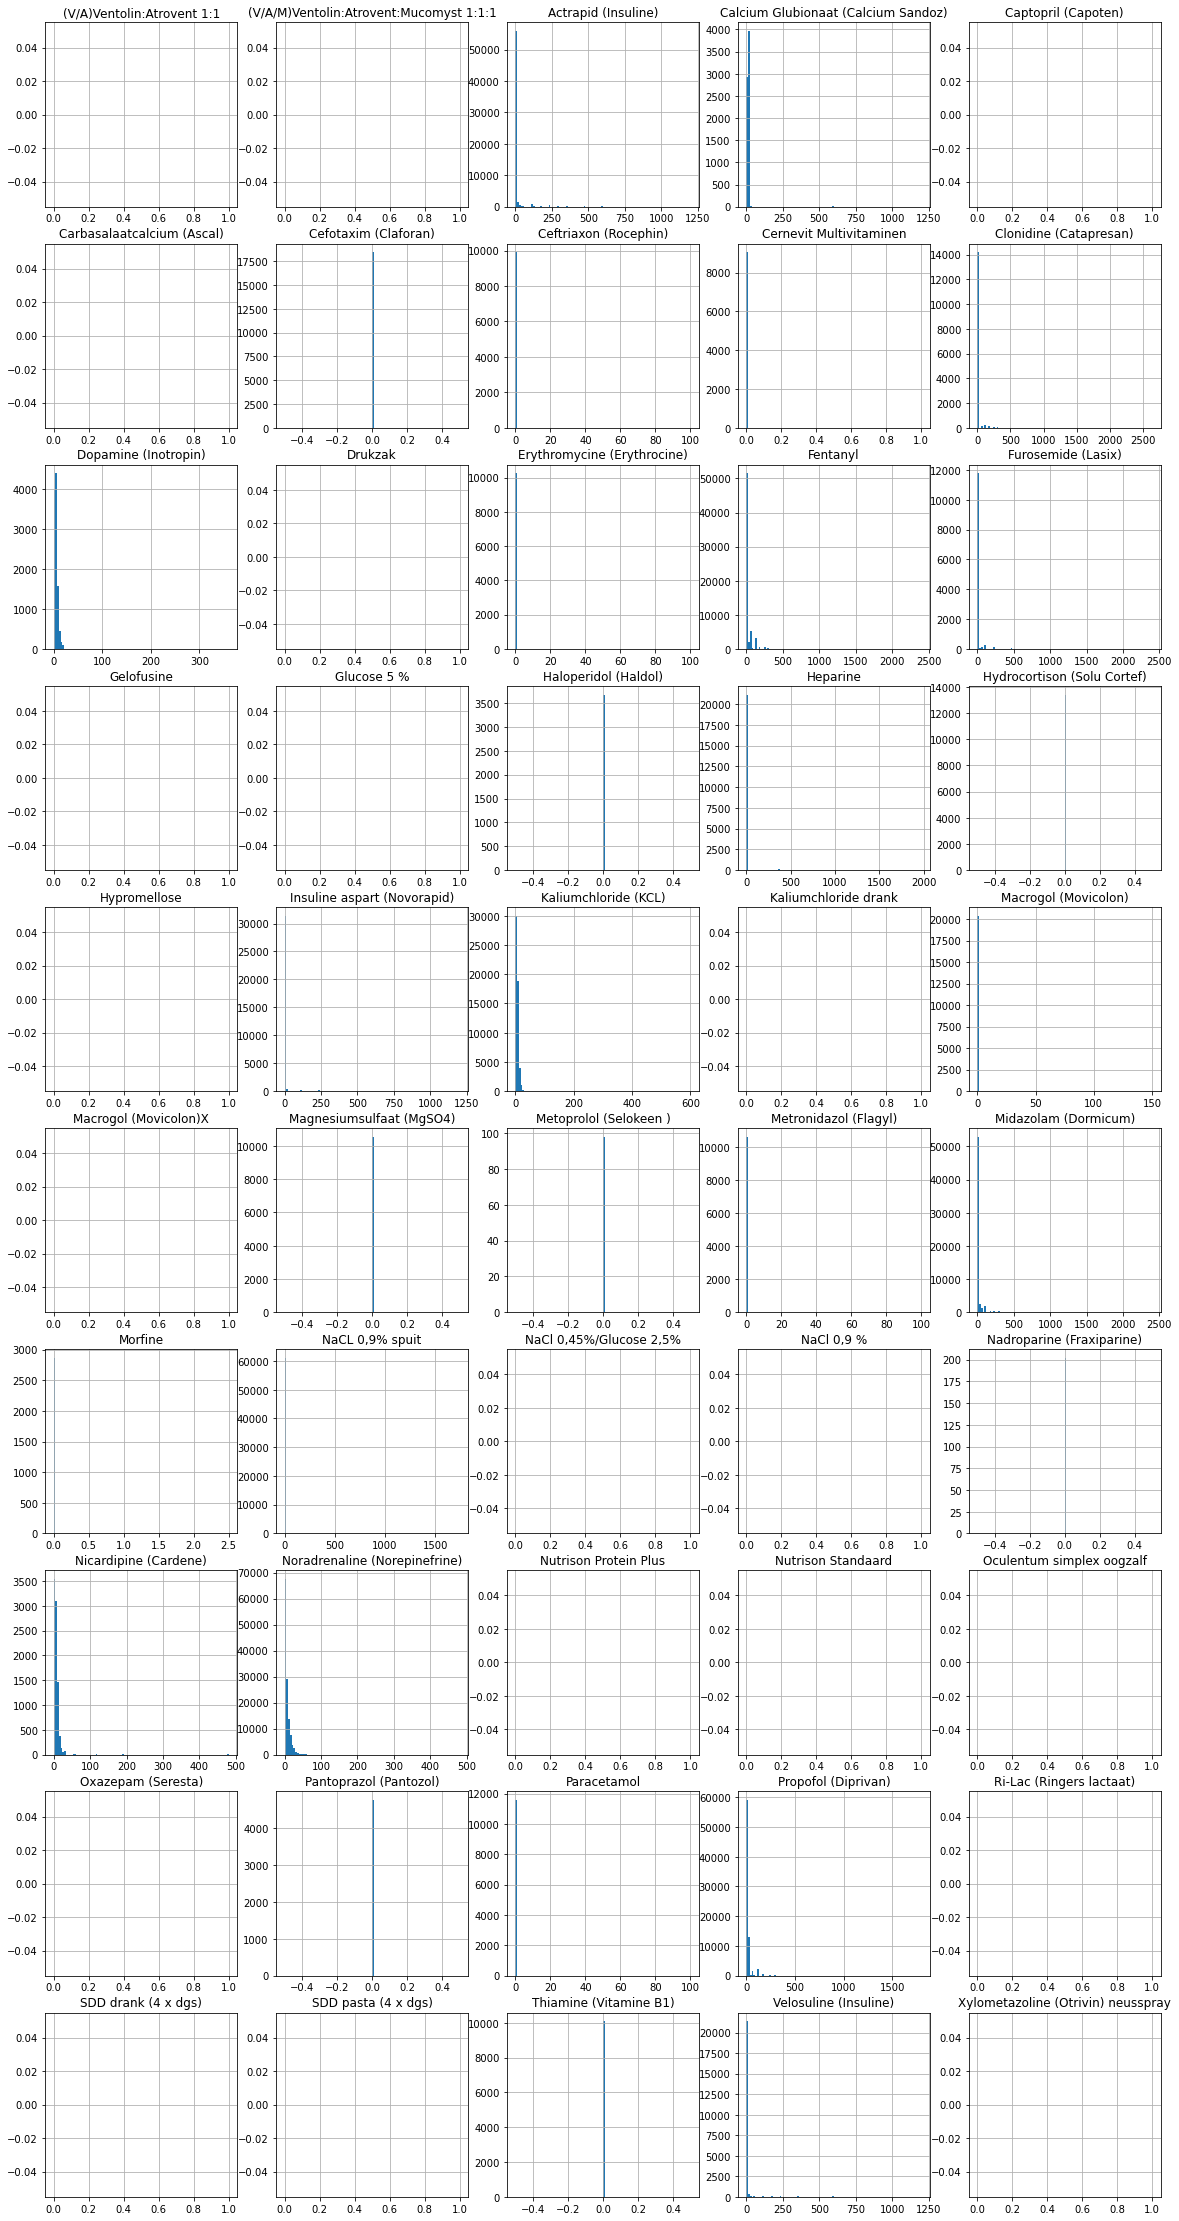

In [15]:
plt.figure(figsize=(20, 40))
for i, item in enumerate(sorted(drg["item"].unique())):
    plt.subplot(10, 5, 1+i)
    drg["rate"][drg["item"] == item].hist(bins=100)
    plt.title(item)

In [16]:
# Clean rate outliers

In [17]:
drg.to_csv(os.path.join(save_path, "drugitems.csv"))